In [1]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

os.chdir("C:/Users/yotam/code_projects/APDTFlow")
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
print("Project root added to sys.path:", project_root)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from torch.utils.data import DataLoader
from apdtflow.data import TimeSeriesWindowDataset
from apdtflow.models.apdtflow import APDTFlow
import pandas as pd
import numpy as np
from apdtflow.models.apdtflow import APDTFlow
from torch.utils.data import Subset

Project root added to sys.path: C:\Users\yotam
CUDA available: False


In [2]:
original_csv = "C:/Users/yotam/code_projects/APDTFlow/dataset_examples/daily-minimum-temperatures-in-me.csv"
clean_csv = "C:/Users/yotam/code_projects/APDTFlow/dataset_examples/daily-minimum-temperatures-in-me_clean.csv"

df = pd.read_csv(original_csv)
df["Daily minimum temperatures"] = pd.to_numeric(df["Daily minimum temperatures"], errors='coerce')
df = df.dropna(subset=["Daily minimum temperatures"])
df["Daily minimum temperatures"] = df["Daily minimum temperatures"].astype(np.float32)
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date", inplace=True)
df.to_csv(clean_csv, index=False)

print("Clean CSV saved to:", clean_csv)
csv_file = "C:/Users/yotam/code_projects/APDTFlow/dataset_examples/daily-minimum-temperatures-in-me_clean.csv"


def normalize_tensor(x):
    return (x - mean_val) / std_val

def denormalize_tensor(x):
    return x * std_val + mean_val

csv_file = clean_csv
date_col = "Date"
value_col = "Daily minimum temperatures"

T_in = 30  
T_out = 7 
df = pd.read_csv(csv_file)
df[value_col] = df[value_col].astype(np.float32)
values = df[value_col].values
mean_val = values.mean()
std_val = values.std()

dataset = TimeSeriesWindowDataset(
    csv_file=csv_file,
    date_col=date_col,
    value_col=value_col,
    T_in=T_in,
    T_out=T_out,
    transform=normalize_tensor 
)

print("Dataset loaded. Total samples:", len(dataset))

def time_series_splits(dataset, train_size, step_size):
    """
    Yields train and validation indices for a rolling window split.
    
    Args:
        dataset (Dataset): The full dataset.
        train_size (int): Number of consecutive samples for training.
        step_size (int): Step size to move the window forward.
        
    Yields:
        (train_indices, val_indices): Tuple of lists of indices.
    """
    n_samples = len(dataset)
    for start in range(0, n_samples - train_size, step_size):
        train_indices = list(range(start, start + train_size))
        val_indices = list(range(start + train_size, min(start + train_size + step_size, n_samples)))
        yield train_indices, val_indices

train_size = 400 
step_size = 803 

splits = list(time_series_splits(dataset, train_size, step_size))
print("Number of CV splits:", len(splits))

def train_on_split(model, train_loader, val_loader, num_epochs, learning_rate, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if x_batch.dim() == 4 and x_batch.size(1) == 1:
                x_batch = x_batch.squeeze(1)
            batch_size, _, T_in_current = x_batch.size()
            t_span = torch.linspace(0, 1, steps=T_in_current, device=device)
            optimizer.zero_grad()
            preds, pred_logvars = model(x_batch, t_span)
            mse = (preds - y_batch.transpose(1, 2)) ** 2
            loss = torch.mean(0.5 * (mse / (pred_logvars.exp() + 1e-6)) + 0.5 * pred_logvars)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_size
        avg_loss = epoch_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}")
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if x_batch.dim() == 4 and x_batch.size(1) == 1:
                x_batch = x_batch.squeeze(1)
            batch_size, _, T_in_current = x_batch.size()
            t_span = torch.linspace(0, 1, steps=T_in_current, device=device)
            preds, pred_logvars = model(x_batch, t_span)
            mse = (preds - y_batch.transpose(1, 2)) ** 2
            loss = torch.mean(0.5 * (mse / (pred_logvars.exp() + 1e-6)) + 0.5 * pred_logvars)
            val_loss += loss.item() * batch_size
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    return avg_val_loss

cv_val_losses = []
for i, (train_indices, val_indices) in enumerate(time_series_splits(dataset, train_size, step_size)):
    print(f"\n--- CV Split {i+1} ---")
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    train_loader_cv = DataLoader(train_subset, batch_size=16, shuffle=False)
    val_loader_cv = DataLoader(val_subset, batch_size=16, shuffle=False)
    model_cv = APDTFlow(
        num_scales=3,
        input_channels=1,
        filter_size=5,
        hidden_dim=32,
        output_dim=1,
        forecast_horizon=T_out
    )
    model_cv.to(device)
    
    num_epochs = 35 
    learning_rate = 0.001
    val_loss = train_on_split(model_cv, train_loader_cv, val_loader_cv, num_epochs, learning_rate, device)
    cv_val_losses.append(val_loss)

print("\nCV Validation Losses:", cv_val_losses)
print("Average CV Validation Loss:", np.mean(cv_val_losses))

Clean CSV saved to: C:/Users/yotam/code_projects/APDTFlow/dataset_examples/daily-minimum-temperatures-in-me_clean.csv
Dataset loaded. Total samples: 3611
Number of CV splits: 4

--- CV Split 1 ---
Epoch 1/35, Training Loss: 19.0420
Epoch 2/35, Training Loss: 4.6924
Epoch 3/35, Training Loss: 3.8352
Epoch 4/35, Training Loss: 3.5099
Epoch 5/35, Training Loss: 3.3075
Epoch 6/35, Training Loss: 3.1696
Epoch 7/35, Training Loss: 3.0680
Epoch 8/35, Training Loss: 2.9910
Epoch 9/35, Training Loss: 2.9295
Epoch 10/35, Training Loss: 2.8769
Epoch 11/35, Training Loss: 2.8351
Epoch 12/35, Training Loss: 2.7933
Epoch 13/35, Training Loss: 2.7502
Epoch 14/35, Training Loss: 2.7043
Epoch 15/35, Training Loss: 2.6596
Epoch 16/35, Training Loss: 2.6118
Epoch 17/35, Training Loss: 2.5639
Epoch 18/35, Training Loss: 2.5124
Epoch 19/35, Training Loss: 2.4569
Epoch 20/35, Training Loss: 2.4060
Epoch 21/35, Training Loss: 2.3475
Epoch 22/35, Training Loss: 2.2898
Epoch 23/35, Training Loss: 2.2367
Epoch 

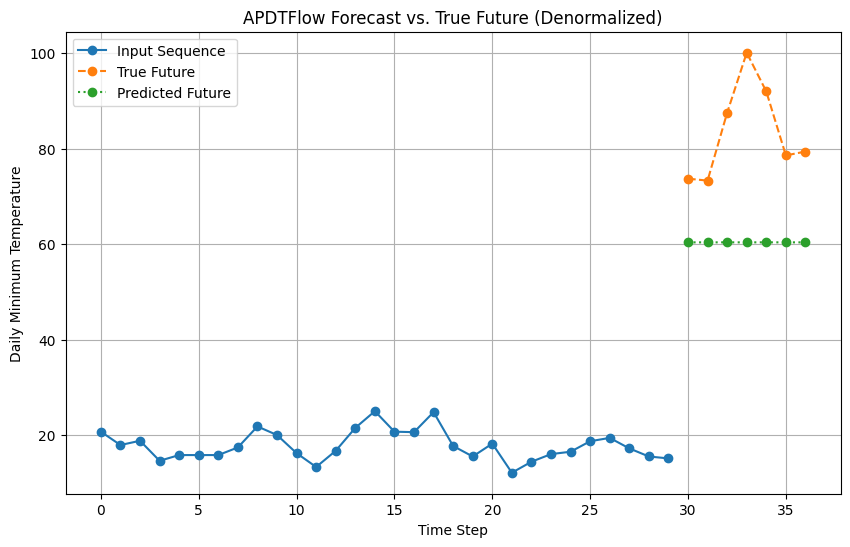

In [ ]:
full_loader = DataLoader(dataset, batch_size=16, shuffle=False)
x_batch, y_batch = next(iter(full_loader))
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)
if x_batch.dim() == 4 and x_batch.size(1) == 1:
    x_batch = x_batch.squeeze(1)

batch_size, _, T_in_current = x_batch.size()
t_span = torch.linspace(0, 1, steps=T_in_current, device=device)

with torch.no_grad():
    preds, _ = model_cv(x_batch, t_span)

sample_idx = 0
input_sequence = x_batch[sample_idx].cpu().numpy().flatten() 
true_future = y_batch[sample_idx].cpu().numpy().flatten() 
predicted_future = preds[sample_idx].cpu().numpy().flatten()
input_sequence_denorm = denormalize_tensor(torch.tensor(input_sequence)).numpy()
true_future_denorm = denormalize_tensor(torch.tensor(true_future)).numpy()
predicted_future_denorm = denormalize_tensor(torch.tensor(predicted_future)).numpy()
input_timesteps = np.arange(T_in)
future_timesteps = np.arange(T_in, T_in + T_out)
plt.figure(figsize=(10, 6))
plt.plot(input_timesteps, input_sequence_denorm, label="Input Sequence", marker='o')
plt.plot(future_timesteps, true_future_denorm, label="True Future", marker='o', linestyle="--")
plt.plot(future_timesteps, predicted_future_denorm, label="Predicted Future", marker='o', linestyle=":")
plt.xlabel("Time Step")
plt.ylabel("Daily Minimum Temperature")
plt.title("APDTFlow Forecast vs. True Future (Denormalized)")
plt.legend()
plt.grid(True)
plt.show()